# INSTALL LIBRARY

In [314]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [315]:
pip install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [316]:
import pandas as pd
import numpy as np
import re
from underthesea import word_tokenize,pos_tag
# from pyvi import ViTokenizer, ViPosTagger
import seaborn as sns
from matplotlib import pyplot as plt
from keras.utils import to_categorical


In [317]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-8s813mqz
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-8s813mqz
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done


In [318]:
from keras.initializers import Constant
from keras.layers import Dense,Input,GlobalAveragePooling1D ,concatenate,Dropout,GRU,Bidirectional,TimeDistributed, Embedding, Attention, LSTM,Convolution1D,MaxPooling1D,Flatten,SpatialDropout1D,LeakyReLU,AveragePooling1D,MultiHeadAttention,GlobalMaxPooling1D,Dropout
from keras.models import Model
from keras.optimizers import Adamax,Adam
from keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from keras.regularizers import L1,L2
# from tensorflow_addons.layers import CRF
# from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from keras_contrib.layers import CRF
from keras.initializers import Orthogonal
from keras.callbacks import EarlyStopping

In [319]:
from keras_contrib.losses import crf_loss

In [320]:
from sklearn.metrics import classification_report,f1_score,precision_score,recall_score,classification_report


In [321]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# LOAD DATA

## PREPROCESSING

In [322]:
class Preprocessing:
    def __init__(self):
        self.vowels_to_ids = {}
        self.vowels_table = [
            ['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a' ],
            ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
            ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
            ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e' ],
            ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
            ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i' ],
            ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o' ],
            ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'o'],
            ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
            ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u' ],
            ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
            ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y' ]
        ]
        pass

    def createVowelsTable(self):
        """Create Vowels Table"""
        for i in range(len(self.vowels_table)):
            for j in range(len(self.vowels_table[i]) - 1):
                self.vowels_to_ids[self.vowels_table[i][j]] = (i, j)

    def IsValidVietnameseWord(self,word):
        """Nguyên âm chỉ có thể đứng chung với nguyên âm. Một từ không thể có 2 nguyên âm cách nhau bởi 1 phụ âm"""
        chars = list(word)
        #nguyen am
        vowel_index = -1
        for i in range(len(chars)):
            idx_vowel_table = self.vowels_to_ids.get(chars[i],(-1,-1))[0]
            if idx_vowel_table != -1:
                if vowel_index == -1:
                    vowel_index = i 
                else:
                    if i - vowel_index != 1:
                        return False
                    vowel_index = i
        return True

    def WordStandardized(self,word):
        """Standardize Word"""
        if not self.IsValidVietnameseWord(word):
            return word

        chars = list(word)
        vowel_indexes = []

        # tìm vị trí nguyên âm
        qu_or_gi = False
        thanh_dieu = 0
        for i in range(len(chars)):
            vowel_table_row, vowel_table_col = self.vowels_to_ids.get(chars[i],(-1,-1))
            if vowel_table_row == -1 :
                continue
            # qu
            if vowel_table_row == 9:
                if i != 0 and chars[i-1] == 'q':
                    chars[i] = 'u'
                    qu_or_gi = True
            # gi
            elif vowel_table_row == 5:
                if i != 0 and chars[i-1] == 'g':
                    chars[i] = 'i'
                    qu_or_gi = True

            # có chứa thanh điệu
            if vowel_table_col != 0:
                thanh_dieu = vowel_table_col
                chars[i] = self.vowels_table[vowel_table_row][0]

            vowel_indexes.append(i)
        # 1 nguyên âm
        if len(vowel_indexes) == 1:
            c = chars[vowel_indexes[0]]
            chars[vowel_indexes[0]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
            return ''.join(chars)

        for idx_vowel in vowel_indexes:
            vowel_table_row, vowel_table_col = self.vowels_to_ids.get(chars[idx_vowel],(-1,-1))
            #ê, ơ, ô
            if vowel_table_row == 4 or vowel_table_row == 7 or vowel_table_row == 8:
                c = chars[idx_vowel]
                chars[idx_vowel] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                return ''.join(chars)

            # kiểm tra qu và gi, 2-3 nguyên âm thì nguyên âm thứ 2 chứa dấu
            if qu_or_gi:
                if len(vowel_indexes) == 2 or len(vowel_indexes) == 3:
                    c = chars[vowel_indexes[1]]
                    chars[vowel_indexes[1]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                return ''.join(chars)
            
            # 2 nguyên âm
            if len(vowel_indexes) == 2:
                # âm cuối là nguyên âm
                if vowel_indexes[-1] == len(chars) - 1:
                    c = chars[vowel_indexes[0]]
                    chars[vowel_indexes[0]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                else:
                    c = chars[vowel_indexes[-1]]
                    chars[vowel_indexes[-1]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                return ''.join(chars)
            
            elif len(vowel_indexes) == 3:
                # âm cuối là nguyên âm
                if vowel_indexes[-1] == len(chars) - 1:
                    c = chars[vowel_indexes[1]]
                    chars[vowel_indexes[1]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                else:
                    c = chars[vowel_indexes[-1]]
                    chars[vowel_indexes[-1]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                return ''.join(chars)

        return ''.join(chars)

    def TextNormalized(self,text):

        #Chuyen sang viet thuong
        text = text.lower()
        # Rút gọn từ kéo dài
        text = re.sub(r'(\w)\1+',r'\1',text)

        # xóa các emoji dư thừa
        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'',text) # no emoji
            
        # dấu sát từ thì cách ra
        text = re.sub(r'([\.\?\/\\\-\+~`#$%!:\"\;\'\|\{\}\[\],])', r' \1 ',text)
        text = text.replace(".",',')
        text = text.split()
        # chuẩn hóa thanh điệu
        for i in range(len(text)):
            text[i] = self.WordStandardized(text[i])

        text = ' '.join(text)

        # text = word_tokenize(text,format = 'text')

        # xóa kí tự thừa 
        # text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđÁÀẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬÉÈẺẼẸÊẾỀỂỄỆÓÒỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÍÌỈĨỊÚÙỦŨỤƯỨỪỬỮỰÝỲỶỸỴĐ_]', ' ', text)
        text = text.strip('\"').strip()

        # xóa space
        text = re.sub(r"( )\1+",r'\1',text)
        
        return text

In [323]:
def prepare_data(data):
    """Return Clean text and Label"""
    texts = data['text'].values
    labels = data['label'].values

    process = Preprocessing()
    annotate = []
    clean_text = []
    pos_tags = []
    for text,label in zip(texts,labels):
        _len = len(label)

        label = np.array(label)
        pair_indexes = label[:,:2]
        aspect_polarity = label[:,-1]
        
        start = 0 

        temp = []
        full = ""
        # print(text)

        for p,a in zip(pair_indexes,aspect_polarity):
            p = np.array(p,dtype=int)
            if start != p[0] :
                t = text[start:p[0]] 
                t = process.TextNormalized(t).split()
                full += ' '.join(t) + " "
                temp.extend(["O" for i in range(len(t))])
            
            #
            start = p[1] 
            t = text[p[0]:p[1]]
            t = process.TextNormalized(t).split()
            temp.extend(["I-"+a if i != 0 else "B-"+a for i in range(len(t))])
            full += ' '.join(t) + " "

        if pair_indexes[-1,-1] != len(full):
            t = text[int(pair_indexes[-1,1]):]
            t = process.TextNormalized(t).split()
            temp.extend(["O" for i in range(len(t))])
            full += ' '.join(t) + " "

        annotate.append(temp)
        clean_text.append(full)
            
        # ptags = []
        # for w in full.split():

        #     ptag = np.array(pos_tag(w))[0][1]
        #     ptags.append(ptag)
        # pos_tags.append(ptags)

        # print(full)
        # z = full.split()
        # for k,v in zip(z,temp):
        #     print(k,v)
        # print(temp)
        # print("JEJE")  
        # print(full.split(),ptags)
        # print(np.array(pos_tag(full)))
        # assert len(ptags) == len(full.split())
    return clean_text,annotate

## READ DATA

In [324]:
train_data = pd.read_json("/content/drive/MyDrive/deep/data/train_data.txt",lines=True).drop(columns=['id','Comments'])
val_data = pd.read_json("/content/drive/MyDrive/deep/data/val_data.txt",lines=True).drop(columns=['id','Comments'])
test_data = pd.read_json("/content/drive/MyDrive/deep/data/test_data.txt",lines=True).drop(columns=['id','Comments'])

## VISUALIZE

In [325]:
dic = {}
for l in train_data.iloc[:,1]:
    for c in l:
        if c[2] not in dic:
            dic[c[2]] = 1
            continue
        dic[c[2]] += 1
dic

{'PERFORMANCE#POSITIVE': 369,
 'FANS_COOLING#NEGATIVE': 35,
 'MULTIMEDIA_DEVICES#POSITIVE': 56,
 'BATTERY#POSITIVE': 67,
 'DESIGN#NEGATIVE': 10,
 'DISPLAY#POSITIVE': 144,
 'KEYBOARD#POSITIVE': 42,
 'GENERAL#POSITIVE': 294,
 'SERVICE#POSITIVE': 137,
 'BATTERY#NEUTRAL': 16,
 'STORAGE#POSITIVE': 19,
 'DESIGN#POSITIVE': 257,
 'FEATURES#POSITIVE': 53,
 'MULTIMEDIA_DEVICES#NEGATIVE': 24,
 'PRICE#POSITIVE': 31,
 'DISPLAY#NEGATIVE': 25,
 'BATTERY#NEGATIVE': 42,
 'CONNECTIVITY#POSITIVE': 24,
 'SERVICE#NEGATIVE': 8,
 'PERFORMANCE#NEUTRAL': 19,
 'FANS_COOLING#POSITIVE': 44,
 'FEATURES#NEGATIVE': 15,
 'PERFORMANCE#NEGATIVE': 35,
 'DISPLAY#NEUTRAL': 7,
 'FANS_COOLING#NEUTRAL': 10,
 'GENERAL#NEGATIVE': 29,
 'GENERAL#NEUTRAL': 14,
 'WARRATY#POSITIVE': 11,
 'PRICE#NEGATIVE': 3,
 'MULTIMEDIA_DEVICES#NEUTRAL': 7,
 'KEYBOARD#NEUTRAL': 2,
 'KEYBOARD#NEGATIVE': 7,
 'FEATURES#NEUTRAL': 1,
 'TOUCHPAD#NEGATIVE': 4,
 'TOUCHPAD#POSITIVE': 4,
 'WARRATY#NEGATIVE': 2,
 'DESIGN#NEUTRAL': 1,
 'SERVICE#NEUTRAL': 1,
 

In [326]:
bar = pd.DataFrame(dic,index=[0])
bar

,PERFORMANCE#POSITIVE,FANS_COOLING#NEGATIVE,MULTIMEDIA_DEVICES#POSITIVE,BATTERY#POSITIVE,DESIGN#NEGATIVE,DISPLAY#POSITIVE,KEYBOARD#POSITIVE,GENERAL#POSITIVE,SERVICE#POSITIVE,BATTERY#NEUTRAL,...,KEYBOARD#NEUTRAL,KEYBOARD#NEGATIVE,FEATURES#NEUTRAL,TOUCHPAD#NEGATIVE,TOUCHPAD#POSITIVE,WARRATY#NEGATIVE,DESIGN#NEUTRAL,SERVICE#NEUTRAL,CONNECTIVITY#NEUTRAL,STORAGE#NEGATIVE
0,369,35,56,67,10,144,42,294,137,16,...,2,7,1,4,4,2,1,1,1,1


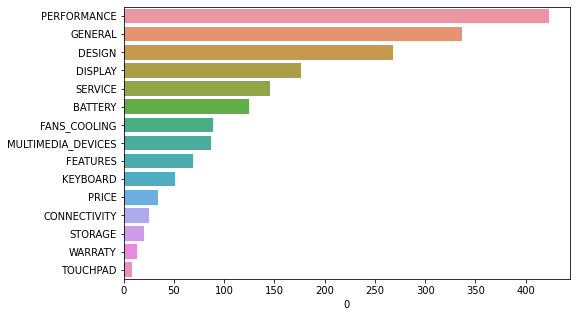

In [327]:
sum_bar = bar.groupby(by = bar.columns.str.extract(r"(\w+)",expand=False),axis=1).sum().T.sort_values(by=0,ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(y=sum_bar.index,x=sum_bar[0])


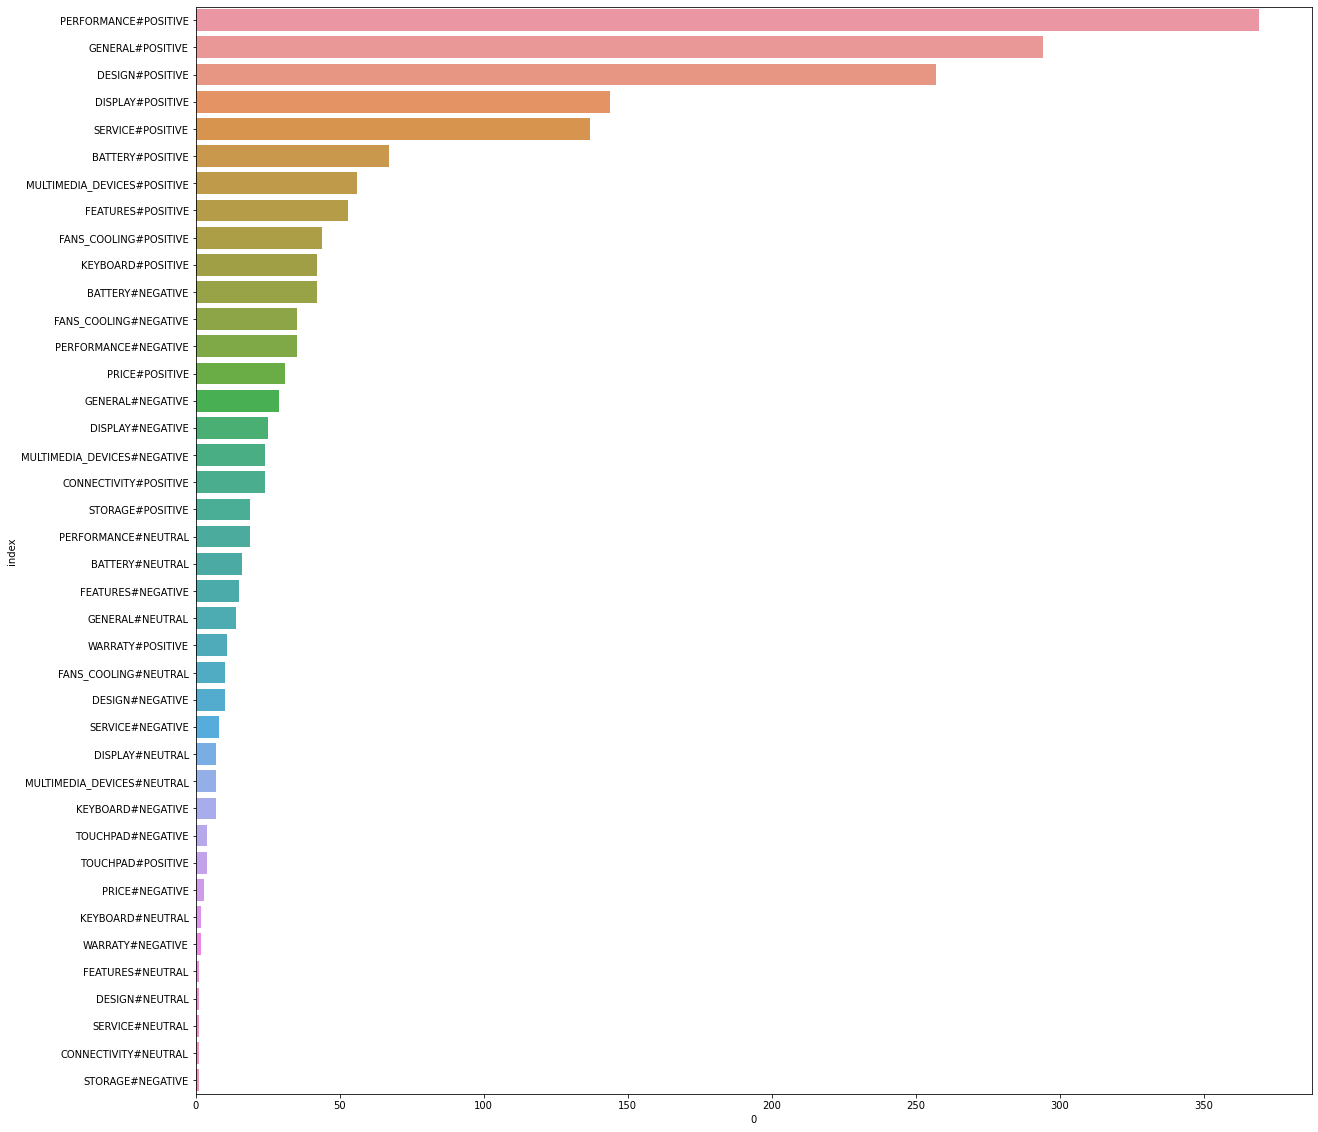

In [328]:
bar = pd.DataFrame(dic,index=[0]).T.sort_values(by=0,ascending=False).reset_index()
plt.figure(figsize=(20,20))
sns.barplot(y=bar['index'],x=bar[0])

In [329]:
X_train,y_train = prepare_data(train_data)
X_val, y_val = prepare_data(val_data)
X_test, y_test = prepare_data(test_data)

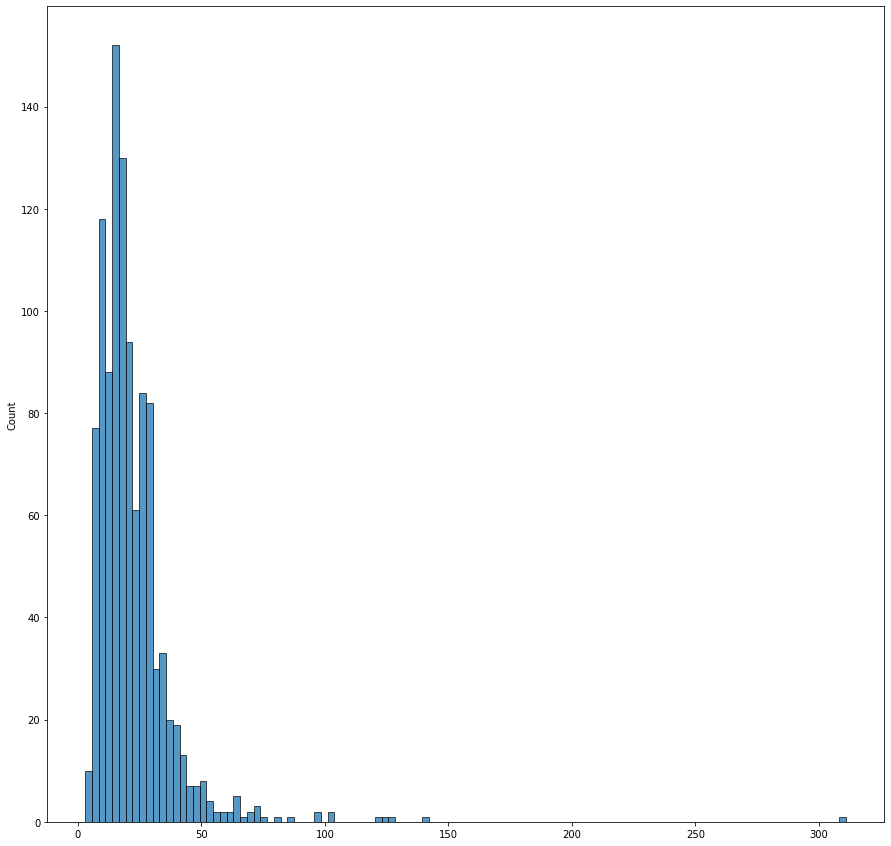

In [330]:
temp = []
for k in X_train:
    k = k.split()
    temp.append(len(k))
plt.figure(figsize = (15,15))
sns.histplot(temp)

In [331]:
MAX_LEN = 30

In [332]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

# Embedding

## WORD EMBEDDING

In [333]:
f= open('/content/drive/MyDrive/deep/word2vec_vi_syllables_100dims.txt','r',encoding='utf-8')
words = []
embedding_words = {}

i = 0
for line in f:
  if i == 0:
    i+= 1
    continue
  value = line.split(' ')
  word = value[0]
  words.append(word)
  try:
    coefs = value[1:]
    embedding_words[word] = np.asarray(coefs,dtype=np.float32)
  except:
    pass


In [334]:
embedding_dim = 100

In [335]:
num_word = len(words)

In [336]:
word2idx = {w:i for i,w in enumerate(words,start = 2)}
word2idx['PAD'] = 0
word2idx['UNK'] = 1

In [337]:
idx2word = {i:w for w,i in word2idx.items()}

In [338]:
with open("/content/drive/MyDrive/deep/data/label.txt",encoding = 'utf-8') as f:
    la = f.readlines()

for i in range(len(la)):
   la[i] = la[i].strip("\n") 
la = np.array(la,dtype='object')
la

array(['GENERAL#POSITIVE', 'GENERAL#NEUTRAL', 'GENERAL#NEGATIVE',
       'DISPLAY#POSITIVE', 'DISPLAY#NEUTRAL', 'DISPLAY#NEGATIVE',
       'BATTERY#POSITIVE', 'BATTERY#NEUTRAL', 'BATTERY#NEGATIVE',
       'TOUCHPAD#POSITIVE', 'TOUCHPAD#NEUTRAL', 'TOUCHPAD#NEGATIVE',
       'KEYBOARD#POSITIVE', 'KEYBOARD#NEUTRAL', 'KEYBOARD#NEGATIVE',
       'SERVICE#POSITIVE', 'SERVICE#NEUTRAL', 'SERVICE#NEGATIVE',
       'WARRATY#POSITIVE', 'WARRATY#NEUTRAL', 'WARRATY#NEGATIVE',
       'STORAGE#POSITIVE', 'STORAGE#NEUTRAL', 'STORAGE#NEGATIVE',
       'CONNECTIVITY#POSITIVE', 'CONNECTIVITY#NEUTRAL',
       'CONNECTIVITY#NEGATIVE', 'MULTIMEDIA_DEVICES#POSITIVE',
       'MULTIMEDIA_DEVICES#NEUTRAL', 'MULTIMEDIA_DEVICES#NEGATIVE',
       'DESIGN#POSITIVE', 'DESIGN#NEUTRAL', 'DESIGN#NEGATIVE',
       'FANS_COOLING#POSITIVE', 'FANS_COOLING#NEUTRAL',
       'FANS_COOLING#NEGATIVE', 'PERFORMANCE#POSITIVE',
       'PERFORMANCE#NEUTRAL', 'PERFORMANCE#NEGATIVE', 'PRICE#POSITIVE',
       'PRICE#NEUTRAL', 'PRICE#N

In [339]:
bi = "B-" + la
ii = "I-" + la

In [340]:
bi

array(['B-GENERAL#POSITIVE', 'B-GENERAL#NEUTRAL', 'B-GENERAL#NEGATIVE',
       'B-DISPLAY#POSITIVE', 'B-DISPLAY#NEUTRAL', 'B-DISPLAY#NEGATIVE',
       'B-BATTERY#POSITIVE', 'B-BATTERY#NEUTRAL', 'B-BATTERY#NEGATIVE',
       'B-TOUCHPAD#POSITIVE', 'B-TOUCHPAD#NEUTRAL', 'B-TOUCHPAD#NEGATIVE',
       'B-KEYBOARD#POSITIVE', 'B-KEYBOARD#NEUTRAL', 'B-KEYBOARD#NEGATIVE',
       'B-SERVICE#POSITIVE', 'B-SERVICE#NEUTRAL', 'B-SERVICE#NEGATIVE',
       'B-WARRATY#POSITIVE', 'B-WARRATY#NEUTRAL', 'B-WARRATY#NEGATIVE',
       'B-STORAGE#POSITIVE', 'B-STORAGE#NEUTRAL', 'B-STORAGE#NEGATIVE',
       'B-CONNECTIVITY#POSITIVE', 'B-CONNECTIVITY#NEUTRAL',
       'B-CONNECTIVITY#NEGATIVE', 'B-MULTIMEDIA_DEVICES#POSITIVE',
       'B-MULTIMEDIA_DEVICES#NEUTRAL', 'B-MULTIMEDIA_DEVICES#NEGATIVE',
       'B-DESIGN#POSITIVE', 'B-DESIGN#NEUTRAL', 'B-DESIGN#NEGATIVE',
       'B-FANS_COOLING#POSITIVE', 'B-FANS_COOLING#NEUTRAL',
       'B-FANS_COOLING#NEGATIVE', 'B-PERFORMANCE#POSITIVE',
       'B-PERFORMANCE#NEUTRAL'

In [341]:
tags = np.append(np.append(bi,ii),"O")
tag2idx = {t:i+1 for i,t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i:t for t,i in tag2idx.items()}

In [342]:
tags

array(['B-GENERAL#POSITIVE', 'B-GENERAL#NEUTRAL', 'B-GENERAL#NEGATIVE',
       'B-DISPLAY#POSITIVE', 'B-DISPLAY#NEUTRAL', 'B-DISPLAY#NEGATIVE',
       'B-BATTERY#POSITIVE', 'B-BATTERY#NEUTRAL', 'B-BATTERY#NEGATIVE',
       'B-TOUCHPAD#POSITIVE', 'B-TOUCHPAD#NEUTRAL', 'B-TOUCHPAD#NEGATIVE',
       'B-KEYBOARD#POSITIVE', 'B-KEYBOARD#NEUTRAL', 'B-KEYBOARD#NEGATIVE',
       'B-SERVICE#POSITIVE', 'B-SERVICE#NEUTRAL', 'B-SERVICE#NEGATIVE',
       'B-WARRATY#POSITIVE', 'B-WARRATY#NEUTRAL', 'B-WARRATY#NEGATIVE',
       'B-STORAGE#POSITIVE', 'B-STORAGE#NEUTRAL', 'B-STORAGE#NEGATIVE',
       'B-CONNECTIVITY#POSITIVE', 'B-CONNECTIVITY#NEUTRAL',
       'B-CONNECTIVITY#NEGATIVE', 'B-MULTIMEDIA_DEVICES#POSITIVE',
       'B-MULTIMEDIA_DEVICES#NEUTRAL', 'B-MULTIMEDIA_DEVICES#NEGATIVE',
       'B-DESIGN#POSITIVE', 'B-DESIGN#NEUTRAL', 'B-DESIGN#NEGATIVE',
       'B-FANS_COOLING#POSITIVE', 'B-FANS_COOLING#NEUTRAL',
       'B-FANS_COOLING#NEGATIVE', 'B-PERFORMANCE#POSITIVE',
       'B-PERFORMANCE#NEUTRAL'

In [343]:
embedding_matrix = np.ones((num_word,embedding_dim))

In [344]:
for w,i in word2idx.items():
  if i > 10000:
    continue
  embedding_vector = embedding_words.get(w)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
  else:
    embedding_matrix[i] = np.random.randn(100)


In [345]:
embedding_matrix

array([[-0.03302622,  0.05436452, -0.04827953, ..., -0.06244506,
        -0.06585843,  0.06980351],
       [ 0.02975786,  0.06155805, -0.0232033 , ..., -0.03034727,
        -0.06321501, -0.041641  ],
       [ 0.00904334, -0.18228702,  0.00215415, ..., -0.06414029,
        -0.02119223, -0.19090103],
       ...,
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [346]:
def encoded(X):
  x_new = []
  for sent in X:
    te = []
    for word in sent.split():
      try:
        te.append(word2idx[word])
      except:
        te.append(word2idx["UNK"])
    x_new.append(te)
  x_new = pad_sequences(x_new,maxlen=MAX_LEN,padding='post',truncating = 'post',value = word2idx['PAD'])
  return x_new

In [347]:
X_train_encoded = encoded(X_train)
X_val_encoded = encoded(X_val)
X_test_encoded = encoded(X_test)


In [348]:
y_train_encoded = [[tag2idx[w] for w in y] for y in y_train]
y_train_encoded = pad_sequences(y_train_encoded,maxlen=MAX_LEN,padding='post',truncating = 'post',value = tag2idx['PAD'])
y_train_encoded = [[to_categorical(z,num_classes = len(tag2idx)) for z in a] for a in y_train_encoded]

y_val_encoded = [[tag2idx[w] for w in y] for y in y_val]
y_val_encoded = pad_sequences(y_val_encoded,maxlen=MAX_LEN,padding='post',truncating = 'post',value = tag2idx['PAD'])
y_val_encoded = [[to_categorical(z,num_classes = len(tag2idx)) for z in a] for a in y_val_encoded]

y_test_encoded = [[tag2idx[w] for w in y] for y in y_test]
y_test_encoded = pad_sequences(y_test_encoded,maxlen=MAX_LEN,padding='post',truncating = 'post',value = tag2idx['PAD'])
y_test_encoded = [[to_categorical(z,num_classes = len(tag2idx)) for z in a] for a in y_test_encoded]


## CHARACTER EMBEDDING

In [349]:
chars = 'aàáảãạăằắẳẵặâầấẩẫậèéẻẽẹeêềếểễệiìíỉĩịoòóỏõọôồốổỗộơờớởỡợuùúủũụưừứửữựyỳýỷỹỵđbcdgsfzhwjklmnpqrtvx0123456789 .!?:,+*\'%-\(\)/$|&;[]🥰🤣❤"'

In [350]:
char2idx = {c:i+2 for i,c in enumerate(list(chars))}
char2idx["UNK"] = 1
char2idx["PAD"] = 0
idx2char = {i:c for c,i in char2idx.items()}

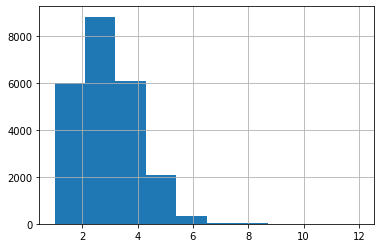

In [351]:
a = []
for s in X_train:
  a.extend(s.split())
pd.DataFrame(a)[0].apply(len).hist()

In [352]:
MAX_CHAR = 5 #So luong ki tu trong 1 tu

In [353]:
def charEncoded(X):
  x = np.zeros((len(X), MAX_LEN, MAX_CHAR), dtype=np.int64) # +Pad

  for i,sentence in enumerate(X):
      sentence = sentence.split()
      for j,word in enumerate(sentence):
          if j > MAX_LEN-1:
              break
          for k,char in enumerate(word):
              if k > MAX_CHAR - 1:
                break
              try:
                  x[i,j,k] = char2idx[char]
              except:
                  print(char)
                  x[i,j,k] = char2idx["UNK"]

  return x


In [354]:
X_train_char_encoded = charEncoded(X_train)
X_val_char_encoded = charEncoded(X_val)
X_test_char_encoded = charEncoded(X_test)


🥲
>
…
…
~
=
>
́
̉
́
̉
̣
̣
́
́
🤗
“
”
́
̃
̣
́
́
̣
“
”
=
̉
🥲


In [355]:
X_test[0]

'mỏng nhẹ , đáp ứng nhiều nhu cầu cần thiết  '

In [356]:
list(map(lambda x: idx2char[x],X_test_char_encoded[0][3]))

['đ', 'á', 'p', 'PAD', 'PAD']

# MODEL

## CRF CLASS

In [357]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode


class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)


## WORD EMBEDDING

In [358]:
input = Input(shape=(MAX_LEN,))
embedding = Embedding(input_dim= len(word2idx), output_dim=100, 
                  input_length=MAX_LEN, embeddings_initializer = Constant(embedding_matrix))(input)  
bi_lstm = Bidirectional(LSTM(units=100, return_sequences=True,
                           recurrent_dropout=0.1))(embedding) 

time = TimeDistributed(Dense(len(tag2idx), activation="softmax"))(bi_lstm) 

crf = CRF(len(tag2idx))  
output = crf(time)

w_model = Model(input,output)
w_model.compile(optimizer=Adamax(learning_rate = 0.005),loss = crf.loss)
w_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 30, 100)           97946000  
                                                                 
 bidirectional_1 (Bidirectio  (None, 30, 200)          160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 92)           18492     
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 30, 92)            8464      
                                                                 
Total params: 98,133,756
Trainable params: 98,133,756
Non-t

In [359]:
callback = EarlyStopping('val_loss',patience = 10,restore_best_weights=True)

In [360]:
# w_model.load_weights("/content/drive/MyDrive/deep/w_weights_last.h5")

In [ ]:
w_model.fit(
    x = X_train_encoded,
    y = np.array(y_train_encoded),
    validation_data = (X_val_encoded,np.array(y_val_encoded)),
    epochs = 50,
    callbacks = [callback],
    batch_size = 2
)

In [ ]:
w_model.save_weights("/content/drive/MyDrive/deep/w_weights_last.h5")

In [383]:
def randomSampleW(text,model,printed = False):
  text = Preprocessing().TextNormalized(text)
  text = text.lower()
  text_encoded = []
  for word in text.split():
    try:
      text_encoded.append(word2idx[word])
    except:
      text_encoded.append(word2idx["UNK"])

  text_encoded = pad_sequences(np.array([text_encoded]),maxlen=MAX_LEN,padding='post',truncating = 'post',value = word2idx['PAD'])

  y_pred = np.argmax(model.predict([text_encoded],verbose = 0),axis = -1)
  if printed:
    print(text)
    for k,v in zip(text.split(),y_pred[0]):
      print(k,idx2tag[v])
  return y_pred

## WORD + CHARACTER EMBEDDING

In [384]:
#NEW
input = Input(shape=(MAX_LEN,),name = 'word_input')
embedding = Embedding(input_dim= len(word2idx), output_dim=100, 
                  input_length=MAX_LEN, embeddings_initializer = Constant(embedding_matrix),trainable = True, name = 'word_embedding')(input)  

char_input = Input(shape=(MAX_LEN, MAX_CHAR),name = 'char_input')
char = TimeDistributed(
    Embedding(input_dim=len(chars) + 2, output_dim = MAX_CHAR,
                input_length=MAX_CHAR,name = 'char_embedding'),name = 'time_char_embedding'
)(char_input)
char = TimeDistributed(
    Bidirectional(
        LSTM(30, return_sequences=False,recurrent_dropout=0.1),
    )
)(char)
# char = TimeDistributed(Flatten())(char)

inputs = concatenate([embedding,char])
inputs = SpatialDropout1D(0.2) (inputs)
bi_lstm = Bidirectional(LSTM(units=100, return_sequences=True,
                           recurrent_dropout=0.1))(inputs) 

time = TimeDistributed(Dense(len(tag2idx), activation="softmax"))(bi_lstm) 


crf_layer = CRF(len(tag2idx))  
output = crf_layer(time)

wc_model = Model(inputs = [input,char_input],outputs = output)
wc_model.compile(optimizer=Adam(learning_rate = 0.005),loss = crf_layer.loss)
wc_model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 30, 5)]      0           []                               
                                                                                                  
 word_input (InputLayer)        [(None, 30)]         0           []                               
                                                                                                  
 time_char_embedding (TimeDistr  (None, 30, 5, 5)    655         ['char_input[0][0]']             
 ibuted)                                                                                          
                                                                                                  
 word_embedding (Embedding)     (None, 30, 100)      97946000    ['word_input[0][0]']       

In [ ]:
callback = EarlyStopping('val_loss',patience = 5,restore_best_weights=True)

In [ ]:
wc_model.load_weights("/content/drive/MyDrive/deep/wc_weights.h5")

In [ ]:
wc_model.fit(
    x = {'word_input':X_train_encoded,'char_input':X_train_char_encoded},
    y = np.array(y_train_encoded),
    validation_data = ([X_val_encoded,X_val_char_encoded],np.array(y_val_encoded)),
    epochs = 50,
    callbacks = [callback],
    batch_size = 2
)

In [ ]:
wc_model.save_weights("/content/drive/MyDrive/deep/wc_weights.h5")

In [385]:
def randomSampleWC(text,model,printed = False):
  text = Preprocessing().TextNormalized(text)
  text = text.lower()
  text_encoded = []
  for word in text.split():
    try:
      text_encoded.append(word2idx[word])
    except:
      text_encoded.append(word2idx["UNK"])

  char_encoded = np.zeros((MAX_LEN, MAX_CHAR), dtype=np.int64) # +Pad
  for j,word in enumerate(text.split()):
      if j > MAX_LEN-1:
          break
      for k,char in enumerate(word):
        if k > MAX_CHAR - 1:
          break
        try:
            char_encoded[j,k] = char2idx[char]
        except:
            char_encoded[j,k] = char2idx["UNK"]

  text_encoded = pad_sequences(np.array([text_encoded]),maxlen=MAX_LEN,padding='post',truncating = 'post',value = word2idx['PAD'])
  # print(text_encoded.shape,np.array([char_encoded]).shape)

  y_pred = np.argmax(model.predict([text_encoded,np.array([char_encoded])],verbose = 0),axis = -1)
  # y_pred = np.argmax(model.predict([text_encoded]),axis = -1)
  if printed:
    print(text)
    for k,v in zip(text.split(),y_pred[0]):
      print(k,idx2tag[v])
  return y_pred

In [ ]:
randomSampleWC("Máy tính xách tay này có màn hình lớn, kiểu dáng mỏng nhẹ. Nhân viên tư vấn nhiệt tình",model)

## WORD + CHARACTER + CONTEXTUAL EMBEDDING

In [362]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [363]:
PRETRAINED_MODEL = "xlm-roberta-base"

In [364]:
from transformers import AutoTokenizer,TFAutoModel
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)


In [365]:
func_token = lambda x: [tokenizer(x,truncation=True,padding='max_length',max_length=MAX_LEN)['input_ids'],tokenizer(x,truncation=True,padding='max_length',max_length=MAX_LEN)['attention_mask']]

In [366]:
x_train_token = np.array(list(map(func_token,X_train)))
x_val_token = np.array(list(map(func_token,X_val)))
x_test_token = np.array(list(map(func_token,X_test)))


In [ ]:
tokenizer.tokenize("máy rất tệ. Mua máy giữa tháng 3 sử dụng 1h thì bị lỗi cam đã được đổi 1 máy mới.",truncation=True,padding='max_length',max_length=MAX_LEN)

In [367]:
# WORD EMBEDDING
input = Input(shape=(MAX_LEN,),name = 'word_input')
embedding = Embedding(input_dim= len(word2idx), output_dim=100, 
                  input_length=MAX_LEN, embeddings_initializer = Constant(embedding_matrix),trainable = True, name = 'word_embedding')(input)  

# CHAR EMBEDDING
char_input = Input(shape=(MAX_LEN, MAX_CHAR),name = 'char_input')
char = TimeDistributed(
    Embedding(input_dim=len(chars) + 2, output_dim = MAX_CHAR,
                input_length=MAX_CHAR,name = 'char_embedding'),name = 'time_char_embedding'
)(char_input)
char = TimeDistributed(
    Bidirectional(
        LSTM(30, return_sequences=False,recurrent_dropout=0.2),
    )
)(char)

# CONTEXTUAL EMBEDDING
input_ids = Input(shape = (MAX_LEN),name = 'input_ids',dtype = np.int32)
attention_mask = Input(shape = (MAX_LEN),name = 'attention_mask',dtype = np.int32)

inputs_pre = [input_ids,attention_mask]

pre_model = TFAutoModel.from_pretrained(PRETRAINED_MODEL, output_hidden_states = 1)
# 0: last_hidden_state, 1: pool
pre_model_output = pre_model(inputs_pre)
pre_model_hidden_state = pre_model_output.hidden_states




All model checkpoint layers were used when initializing TFXLMRobertaModel.

All the layers of TFXLMRobertaModel were initialized from the model checkpoint at xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [368]:
# concatenate_model_output = concatenate(
#     tuple([pre_model_hidden_state[i] for i in range(-4,0)]), axis=-1
#     ) 
# concatenate_model_output = Dropout1D(0.1) (concatenate_model_output)

concatenate_model_output = pre_model_hidden_state[0]
# pre_model_embedding = tf.keras.layers.AveragePooling1D (pool_size = 3, strides = 1, padding = 'same') (concatenate_model_output)

inputs = concatenate([embedding,char,concatenate_model_output])
inputs = SpatialDropout1D(0.2) (inputs)

bi_lstm = Bidirectional(LSTM(units=100, return_sequences=True,
                           recurrent_dropout=0.1))(inputs) 

time = TimeDistributed(Dense(len(tag2idx), activation="softmax"))(bi_lstm) 


crf_layer = CRF(len(tag2idx))  
output = crf_layer(time)

wcc_model = Model(inputs = [input,char_input,[input_ids,attention_mask]],outputs = output)
wcc_model.compile(optimizer=Adamax(0.005),loss = [crf_layer.loss])
wcc_model.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 30, 5)]      0           []                               
                                                                                                  
 word_input (InputLayer)        [(None, 30)]         0           []                               
                                                                                                  
 time_char_embedding (TimeDistr  (None, 30, 5, 5)    655         ['char_input[0][0]']             
 ibuted)                                                                                          
                                                                                                  
 input_ids (InputLayer)         [(None, 30)]         0           []                         

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
callback = EarlyStopping('val_loss',patience = 15,restore_best_weights=True)

In [ ]:
wcc_model.load_weights("/content/drive/MyDrive/deep/context_weights_fhidden_first.h5")

In [ ]:
wcc_model.fit(
    x = [X_train_encoded,X_train_char_encoded,x_train_token[:,0],x_train_token[:,1]],
    y = np.array(y_train_encoded),
    validation_data = ([X_val_encoded,X_val_char_encoded,x_val_token[:,0],x_val_token[:,1]],np.array(y_val_encoded)),
    epochs = 50,
    callbacks = [callback],
    batch_size = 1
)

In [ ]:
# wcc_model.save_weights("/content/drive/MyDrive/deep/context_weights_fhidden_first.h5")

In [371]:
def randomSampleWCC(text,model,tokenizer,printed = False):
  text = Preprocessing().TextNormalized(text)
  text = text.lower()

  text_encoded = []
  for word in text.split():
    try:
      text_encoded.append(word2idx[word])
    except:
      text_encoded.append(word2idx["UNK"])

  char_encoded = np.zeros((MAX_LEN, MAX_CHAR), dtype=np.int64) # +Pad
  for j,word in enumerate(text.split()):
      if j > MAX_LEN-1:
          break
      for k,char in enumerate(word):
        if k > MAX_CHAR - 1:
          break
        try:
            char_encoded[j,k] = char2idx[char]
        except:
            char_encoded[j,k] = char2idx["UNK"]

  text_encoded = pad_sequences(np.array([text_encoded]),maxlen=MAX_LEN,padding='post',truncating = 'post',value = word2idx['PAD'])
  
  token_1 = tokenizer(text,truncation=True,padding='max_length',max_length=MAX_LEN)['input_ids']
  token_2 = tokenizer(text,truncation=True,padding='max_length',max_length=MAX_LEN)['attention_mask']
  
  # print(text_encoded.shape,np.array([char_encoded]).shape)
  
  y_pred = np.argmax(model.predict([text_encoded,np.array([char_encoded]),np.array([token_1]),np.array([token_2])],verbose = 0),axis = -1)
  # y_pred = np.argmax(model.predict([text_encoded]),axis = -1)
  if printed:
    print(text)
    for k,v in zip(text.split(),y_pred[0]):
      print(k,idx2tag[v])
  return y_pred

In [ ]:
randomSampleWCC("Máy có cấu hình mạnh, âm thanh sống động, bảo hành chính hãng nên mọi người in tâm sử dụng",model,tokenizer,True)

# EVALUATE

In [ ]:
y_test_re = np.argmax(y_test_encoded,axis=-1)[:,np.newaxis]
y_test_re

In [ ]:
def convert2Aspect(y_preds,isone = False):
  """Input should be list indicate of tags"""
  y_preds_w_aspect = np.array(y_preds,dtype = 'object').copy()
  _len = len(y_preds_w_aspect)
  for i in range(_len):
    ea = y_preds_w_aspect[i] if _len == 1 else y_preds_w_aspect[i][0]
    # print("EA",ea)
    y_preds_w_tags = list(map(lambda x: idx2tag[x],ea))
    for j in range(len(y_preds_w_tags)):
      try:
        y_preds_w_tags[j] = y_preds_w_tags[j][2:re.search(r"\#",y_preds_w_tags[j]).start()]
      except:
        continue
    y_preds_w_aspect[i] = y_preds_w_tags
  return y_preds_w_aspect

In [ ]:
def convert2Polarity(y_preds):
  """Input should be list indicate of tags"""
  y_preds_w_pola = np.array(y_preds,dtype = 'object').copy()
  _len = len(y_preds_w_pola)
  for i in range(_len):
    ea = y_preds_w_pola[i] if _len == 1 else y_preds_w_pola[i][0]
    
    y_preds_w_tags = list(map(lambda x: idx2tag[x],ea))
    for j in range(len(y_preds_w_tags)):
      try:
        y_preds_w_tags[j] = y_preds_w_tags[j][re.search(r"\#",y_preds_w_tags[j]).start()+1:]
      except:
        continue
    y_preds_w_pola[i] = y_preds_w_tags
  return y_preds_w_pola

In [414]:
def caculateAMetrics(y_test,y_preds,print_report = False):
  f1_scores = []
  precision_scores = []
  recall_scores = []
  if print_report:
    y_test_flatten = []
    y_pred_flatten = []

  for i in range(len(y_test)):
    # yt = np.array(list(map(lambda x: tag2idx[x],y_test[i])))
    yt = pad_sequences([y_test[i][0]],maxlen=MAX_LEN,padding='post',truncating = 'post',value = tag2idx['PAD'])
    # print(yt)
    # yt = np.array(list(map(lambda x: idx2tag[x],yt[0])))
    # print(yt)
    yt = convert2Aspect(yt)[0]
    y_pred = y_preds[i][0]
    # print(yt)
    # print(y_pred)
    # print("==================")
    if print_report:
      y_test_flatten.extend(yt)
      y_pred_flatten.extend(y_pred)

    f1_scores.append(f1_score(yt,y_pred,average = 'macro',zero_division=0))
    precision_scores.append(precision_score(yt,y_pred,average = 'macro',zero_division=0))
    recall_scores.append(recall_score(yt,y_pred,average = 'macro',zero_division=0))

  if print_report:
    print(classification_report(y_test_flatten, y_pred_flatten,zero_division=0))
  return np.mean(precision_scores),np.mean(recall_scores),np.mean(f1_scores)

In [ ]:
def caculatePMetrics(y_test,y_preds,print_report = False):
  f1_scores = []
  precision_scores = []
  recall_scores = []

  if print_report:
    y_test_flatten = []
    y_pred_flatten = []

  for i in range(len(y_test)):
    # yt = np.array(list(map(lambda x: tag2idx[x],y_test[i])))
    yt = pad_sequences([y_test[i][0]],maxlen=MAX_LEN,padding='post',truncating = 'post',value = tag2idx['PAD'])
    # print(yt)
    # yt = np.array(list(map(lambda x: idx2tag[x],yt[0])))
    # print(yt)
    yt = convert2Polarity(yt)[0]
    y_pred = y_preds[i][0]
    # print(yt)
    # print(y_pred)
    # print("==================")
    if print_report:
      y_test_flatten.extend(yt)
      y_pred_flatten.extend(y_pred)

    f1_scores.append(f1_score(yt,y_pred,average = 'macro',zero_division=0))
    precision_scores.append(precision_score(yt,y_pred,average = 'macro',zero_division=0))
    recall_scores.append(recall_score(yt,y_pred,average = 'macro',zero_division=0))
    
  if print_report:
    print(classification_report(y_test_flatten, y_pred_flatten,zero_division=0))

  return np.mean(precision_scores),np.mean(recall_scores),np.mean(f1_scores)

In [431]:
def caculateAPMetrics(y_test,y_preds,print_report = False):
  f1_scores = []
  precision_scores = []
  recall_scores = []
  if print_report:
    y_test_flatten = []
    y_pred_flatten = []
  for i in range(len(y_test)):
    # yt = np.array(list(map(lambda x: tag2idx[x],y_test[i])))
    yt = pad_sequences([y_test[i][0]],maxlen=MAX_LEN,padding='post',truncating = 'post',value = tag2idx['PAD'])[0]
    y_pred = y_preds[i][0]
    yt = list(map(lambda x: idx2tag[x],yt))
    y_pred = list(map(lambda x: idx2tag[x],y_pred))

    # print(yt)
    # print(y_pred)
    # print("==========")
    if print_report:
      # dont get B-, I-
      y_test_flatten.extend(list(map(lambda x:x[2:] if "#" in x else x,yt)))
      y_pred_flatten.extend(list(map(lambda x:x[2:] if "#" in x else x,y_pred)))

    f1_scores.append(f1_score(yt,y_pred,average = 'macro',zero_division=0))
    precision_scores.append(precision_score(yt,y_pred,average = 'macro',zero_division=0))
    recall_scores.append(recall_score(yt,y_pred,average = 'macro',zero_division=0))

  if print_report:
    print(classification_report(y_test_flatten, y_pred_flatten,zero_division=0))
  return np.mean(precision_scores),np.mean(recall_scores),np.mean(f1_scores)

## WORD

In [382]:
w_model.load_weights("/content/drive/MyDrive/deep/w_weights_last.h5")

In [ ]:
y_preds_w = np.array([randomSampleW(x,w_model) for x in X_test])

### ASPECT

In [386]:
y_preds_w_aspect = convert2Aspect(y_preds_w)


In [387]:
y_preds_w_aspect[0]

array([['DESIGN', 'DESIGN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
        'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
        'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
        'PAD', 'PAD']], dtype=object)

In [388]:
w_a_pre,w_a_re,w_a_f1 = caculateAMetrics(y_test_re,y_preds_w_aspect,1)
print("Precision score:",w_a_pre)
print("Recall score:",w_a_re)
print("F1 score:",w_a_f1)

                    precision    recall  f1-score   support

           BATTERY       0.56      0.50      0.53       267
      CONNECTIVITY       0.90      0.52      0.66       176
            DESIGN       0.80      0.73      0.76       742
           DISPLAY       0.57      0.78      0.66       403
      FANS_COOLING       0.68      0.50      0.58       186
          FEATURES       0.53      0.45      0.49       331
           GENERAL       0.41      0.46      0.44       827
          KEYBOARD       0.55      0.79      0.65       169
MULTIMEDIA_DEVICES       0.70      0.67      0.68       271
                 O       0.55      0.52      0.53      1712
               PAD       0.99      1.00      0.99      3744
       PERFORMANCE       0.65      0.72      0.69      1172
             PRICE       0.22      0.07      0.10        89
           SERVICE       0.62      0.67      0.65       362
           STORAGE       0.43      0.54      0.48        70
          TOUCHPAD       0.00      0.00

### POLARITY

In [389]:
y_preds_w_polarity = convert2Polarity(y_preds_w)

In [390]:
y_preds_w_polarity[0]

array([['POSITIVE', 'POSITIVE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
        'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
        'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
        'PAD', 'PAD']], dtype=object)

In [391]:
w_p_pre,w_p_re,w_p_f1 = caculatePMetrics(y_test_re,y_preds_w_polarity,1)
print("Precision score:",w_p_pre)
print("Recall score:",w_p_re)
print("F1 score:",w_p_f1)

              precision    recall  f1-score   support

    NEGATIVE       0.63      0.34      0.44       611
     NEUTRAL       0.22      0.24      0.23       246
           O       0.55      0.52      0.53      1712
         PAD       0.99      1.00      0.99      3744
    POSITIVE       0.80      0.86      0.83      4337

    accuracy                           0.81     10650
   macro avg       0.64      0.59      0.61     10650
weighted avg       0.80      0.81      0.80     10650

Precision score: 0.7035020805068384
Recall score: 0.7172759971029016
F1 score: 0.6847756311176627


### ASPECT#POLARITY

In [432]:
w_ap_pre,w_ap_re,w_ap_f1 = caculateAPMetrics(y_test_re,y_preds_w,1)
print("Precision score:",w_ap_pre)
print("Recall score:",w_ap_re)
print("F1 score:",w_ap_f1)

                             precision    recall  f1-score   support

           BATTERY#NEGATIVE       0.59      0.57      0.58        69
            BATTERY#NEUTRAL       0.55      0.85      0.67        62
           BATTERY#POSITIVE       0.45      0.26      0.33       136
      CONNECTIVITY#NEGATIVE       0.00      0.00      0.00        11
       CONNECTIVITY#NEUTRAL       0.00      0.00      0.00         5
      CONNECTIVITY#POSITIVE       0.90      0.57      0.70       160
            DESIGN#NEGATIVE       0.00      0.00      0.00        66
            DESIGN#POSITIVE       0.76      0.76      0.76       676
           DISPLAY#NEGATIVE       0.40      0.39      0.40        69
           DISPLAY#POSITIVE       0.55      0.79      0.65       334
      FANS_COOLING#NEGATIVE       0.38      0.15      0.22        33
       FANS_COOLING#NEUTRAL       0.00      0.00      0.00        16
      FANS_COOLING#POSITIVE       0.95      0.61      0.75       137
          FEATURES#NEGATIVE      

## WORD + CHARACTER

In [404]:
wc_model.load_weights("/content/drive/MyDrive/deep/wc_weights.h5")

In [405]:
y_preds_wc = [randomSampleWC(x,wc_model) for x in X_test]

### ASPECT

In [406]:
y_preds_wc_aspect = convert2Aspect(y_preds_wc)


In [407]:
y_preds_wc_aspect[0]

array([['DESIGN', 'DESIGN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
        'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
        'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
        'PAD', 'PAD']], dtype=object)

In [408]:
wc_a_pre,wc_a_re,wc_a_f1 = caculateAMetrics(y_test_re,y_preds_wc_aspect,1)
print("Precision score:",wc_a_pre)
print("Recall score:",wc_a_re)
print("F1 score:",wc_a_f1)

                    precision    recall  f1-score   support

           BATTERY       0.46      0.68      0.55       267
      CONNECTIVITY       0.78      0.73      0.76       176
            DESIGN       0.76      0.69      0.73       742
           DISPLAY       0.63      0.62      0.63       403
      FANS_COOLING       0.42      0.48      0.45       186
          FEATURES       0.52      0.59      0.56       331
           GENERAL       0.46      0.46      0.46       827
          KEYBOARD       0.35      0.70      0.46       169
MULTIMEDIA_DEVICES       0.65      0.61      0.63       271
                 O       0.56      0.45      0.50      1712
               PAD       1.00      0.99      0.99      3744
       PERFORMANCE       0.61      0.73      0.66      1172
             PRICE       0.00      0.00      0.00        89
           SERVICE       0.62      0.73      0.67       362
           STORAGE       0.67      0.81      0.74        70
          TOUCHPAD       0.00      0.00

### POLARITY

In [409]:
y_preds_wc_polarity = convert2Polarity(y_preds_wc)

In [410]:
y_preds_wc_polarity[0]

array([['POSITIVE', 'POSITIVE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
        'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
        'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
        'PAD', 'PAD']], dtype=object)

In [411]:
wc_p_pre,wc_p_re,wc_p_f1 = caculatePMetrics(y_test_re,y_preds_wc_polarity,1)
print("Precision score:",wc_p_pre)
print("Recall score:",wc_p_re)
print("F1 score:",wc_p_f1)

              precision    recall  f1-score   support

    NEGATIVE       0.56      0.35      0.43       611
     NEUTRAL       0.12      0.30      0.17       246
           O       0.56      0.45      0.50      1712
         PAD       1.00      0.99      0.99      3744
    POSITIVE       0.82      0.86      0.84      4337

    accuracy                           0.80     10650
   macro avg       0.61      0.59      0.59     10650
weighted avg       0.81      0.80      0.80     10650

Precision score: 0.6875892918722314
Recall score: 0.7055022448958486
F1 score: 0.6717204748376957


### ASPECT#POLARITY

In [433]:
wc_ap_pre,wc_ap_re,wc_ap_f1 = caculateAPMetrics(y_test_re,y_preds_wc,1)
print("Precision score:",wc_ap_pre)
print("Recall score:",wc_ap_re)
print("F1 score:",wc_ap_f1)

                             precision    recall  f1-score   support

           BATTERY#NEGATIVE       0.66      0.36      0.47        69
            BATTERY#NEUTRAL       0.24      0.95      0.39        62
           BATTERY#POSITIVE       0.77      0.62      0.69       136
      CONNECTIVITY#NEGATIVE       0.00      0.00      0.00        11
       CONNECTIVITY#NEUTRAL       0.00      0.00      0.00         5
      CONNECTIVITY#POSITIVE       0.78      0.81      0.79       160
            DESIGN#NEGATIVE       0.00      0.00      0.00        66
            DESIGN#POSITIVE       0.73      0.73      0.73       676
           DISPLAY#NEGATIVE       0.67      0.48      0.56        69
            DISPLAY#NEUTRAL       0.00      0.00      0.00         0
           DISPLAY#POSITIVE       0.68      0.65      0.66       334
      FANS_COOLING#NEGATIVE       1.00      0.12      0.22        33
       FANS_COOLING#NEUTRAL       0.13      0.62      0.21        16
      FANS_COOLING#POSITIVE      

## WORD + CHARACTER + CONTEXTUAL

In [369]:
wcc_model.load_weights("/content/drive/MyDrive/deep/context_weights_fhidden_second.h5")

In [372]:
y_preds_wcc = [randomSampleWCC(x,wcc_model,tokenizer) for x in X_test]

### ASPECT

In [373]:
y_preds_wcc_aspect = convert2Aspect(y_preds_wcc)


In [374]:
y_preds_wcc_aspect[0]

array([['DESIGN', 'DESIGN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
        'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
        'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
        'PAD', 'PAD']], dtype=object)

In [376]:
wcc_a_pre,wcc_a_re,wcc_a_f1 = caculateAMetrics(y_test_re,y_preds_wcc_aspect,1)
print("Precision score:",wcc_a_pre)
print("Recall score:",wcc_a_re)
print("F1 score:",wcc_a_f1)

                    precision    recall  f1-score   support

           BATTERY       0.80      0.65      0.72       267
      CONNECTIVITY       0.96      0.61      0.75       176
            DESIGN       0.82      0.74      0.78       742
           DISPLAY       0.58      0.73      0.65       403
      FANS_COOLING       0.70      0.49      0.58       186
          FEATURES       0.61      0.48      0.54       331
           GENERAL       0.56      0.42      0.48       827
          KEYBOARD       0.82      0.89      0.85       169
MULTIMEDIA_DEVICES       0.77      0.63      0.69       271
                 O       0.57      0.64      0.60      1712
               PAD       0.99      1.00      1.00      3744
       PERFORMANCE       0.63      0.80      0.70      1172
             PRICE       1.00      0.07      0.13        89
           SERVICE       0.64      0.75      0.69       362
           STORAGE       0.46      0.81      0.59        70
          TOUCHPAD       0.00      0.00

### POLARITY

In [377]:
y_preds_wcc_polarity = convert2Polarity(y_preds_wcc)

In [378]:
y_preds_wcc_polarity[0]

array([['POSITIVE', 'POSITIVE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
        'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
        'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
        'PAD', 'PAD']], dtype=object)

In [379]:
wcc_p_pre,wcc_p_re,wcc_p_f1 = caculatePMetrics(y_test_re,y_preds_wcc_polarity,1)
print("Precision score:",wcc_p_pre)
print("Recall score:",wcc_p_re)
print("F1 score:",wcc_p_f1)

              precision    recall  f1-score   support

    NEGATIVE       0.68      0.27      0.39       611
     NEUTRAL       0.32      0.12      0.18       246
           O       0.57      0.64      0.60      1712
         PAD       0.99      1.00      1.00      3744
    POSITIVE       0.81      0.86      0.83      4337

    accuracy                           0.82     10650
   macro avg       0.67      0.58      0.60     10650
weighted avg       0.82      0.82      0.81     10650

Precision score: 0.7161303109607657
Recall score: 0.7271642353109654
F1 score: 0.6982453168315548


### ASPECT#POLARITY

In [434]:
wcc_pre,wcc_re,wcc_f1 = caculateAPMetrics(y_test_re,y_preds_wcc,1)
print("Precision score:",wcc_pre)
print("Recall score:",wcc_re)
print("F1 score:",wcc_f1)

                             precision    recall  f1-score   support

           BATTERY#NEGATIVE       0.43      0.48      0.46        69
            BATTERY#NEUTRAL       0.61      0.44      0.51        62
           BATTERY#POSITIVE       0.41      0.29      0.34       136
      CONNECTIVITY#NEGATIVE       0.00      0.00      0.00        11
       CONNECTIVITY#NEUTRAL       0.00      0.00      0.00         5
      CONNECTIVITY#POSITIVE       0.96      0.68      0.79       160
            DESIGN#NEGATIVE       0.00      0.00      0.00        66
            DESIGN#POSITIVE       0.76      0.75      0.75       676
           DISPLAY#NEGATIVE       0.00      0.00      0.00        69
           DISPLAY#POSITIVE       0.53      0.80      0.64       334
      FANS_COOLING#NEGATIVE       0.00      0.00      0.00        33
       FANS_COOLING#NEUTRAL       0.00      0.00      0.00        16
      FANS_COOLING#POSITIVE       0.70      0.66      0.68       137
          FEATURES#NEGATIVE      